# ML Instant House Valuation: Part 3 - Data exploration and transformation
> In this section, I will be taking the data prepared in the previous section, and manipulating and transforming the data in a format which can be understood by a machine learning model.

- toc:true
- branch: master
- badges: true
- author: Uzair Patel
- categories: [house-prices]

In [ ]:
# collapse
import os, json
import numpy as np
import pandas as pd
import dask.dataframe as dd

# visualisation
from pprint import pprint, pformat
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["figure.dpi"] = 80
sns.set_theme(style="whitegrid")

In [ ]:
# hide
DATASET_PATH = "data/dataset.parquet"
MERGED_PATH = "data/parts/merged"
RAW_PATH = "data/raw"
PCD_PATH = os.path.join(RAW_PATH, "postcode-lookup.csv")
HPI_PATH = os.path.join(RAW_PATH, "house-price-index.csv")

In [ ]:
# hide_input
df = dd.read_parquet(MERGED_PATH).compute()
df.head()

,PRICE,POSTCODE,OLD_NEW,PROPERTY_TYPE,BUILT_FORM,TOTAL_FLOOR_AREA,GLAZED_TYPE,EXTENSION_COUNT,NUMBER_HABITABLE_ROOMS,CONSTRUCTION_AGE_BAND,TENURE
DATE_OF_TRANSFER,,,,,,,,,,,
1995-01-01,16000.0,HX1 4NG,N,House,Enclosed Mid-Terrace,99.00,"double glazing, unknown install date",0.0,4.0,England and Wales: before 1900,owner-occupied
1995-01-02,35000.0,NN1 4LL,N,House,Mid-Terrace,85.00,double glazing installed before 2002,1.0,4.0,England and Wales: 1900-1929,owner-occupied
1995-01-03,15000.0,NE34 8TF,N,House,Semi-Detached,74.00,double glazing installed before 2002,0.0,4.0,England and Wales: 1967-1975,rental (private)
1995-01-03,48000.0,HR8 2DB,N,Bungalow,Detached,78.00,double glazing installed before 2002,1.0,3.0,England and Wales: 1950-1966,owner-occupied
1995-01-03,82000.0,TR13 8BP,N,Bungalow,Detached,118.88,double glazing installed during or after 2002,0.0,4.0,England and Wales: 1967-1975,rental (private)


## Dataset as a time series
I will begin by visualising the dataset with the median monthly housing price as plotted through time.

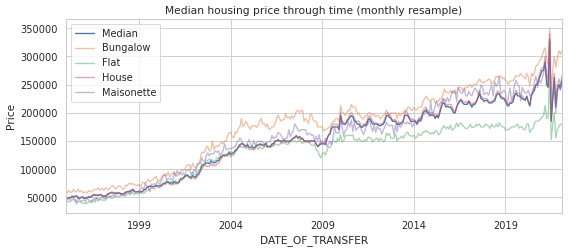

In [ ]:
# hide_input
f, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Median housing price through time (monthly resample)")
ax.set_ylabel("Price")
df.PRICE.resample("M").median().plot(ax=ax, label="Median")
df.groupby("PROPERTY_TYPE").PRICE.resample("M").median().unstack(level=0).drop(
    columns="Park home").plot(ax=ax, alpha=.5)
ax.legend();

### Detrending dataset
In order to be able to predict the price of a property regardless of time, I need to detrend/stationarise the prices uing the house price index. I will use the adjusted prices for the sample outputs in non-extrapolation models (such as decision tree ensembles), as well as visualisation and outlier removal. Additionally, I will add the HPI and data as features and will use the raw prices as outputs for extrapolation models that can learn the time correlation instead.

To adjust the prices:
$$
  \textit{Cost in x} =  \textit{x index} \times \frac{\textit{Cost in y}}{\textit{y index}}\\
$$
Where,  
$x$ : Target date  
$y$ : Original date

The target date index will not be used now, rather it will be used after the model is trained by taking the product of the index and the model output as the prediction.
$$
\textit{Prediction for x} = \textit{Model ouput} \times \textit{x index}
$$

In [ ]:
hpi = pd.read_csv(HPI_PATH, parse_dates=["Date"]).set_index("Date").Index
hpi.plot().set_title("House Price Index");

In [ ]:
idx = pd.DatetimeIndex(df.index.values.astype("datetime64[M]"))  # converting date of transfers to start of month dates
# filling any missing dates in house price index
missing = idx.unique()[~idx.unique().isin(hpi.index)]
if len(missing) > 0:
    hpi = pd.concat([hpi, pd.Series(index=missing, dtype="float64")]).fillna(method="bfill") # backfill nans with previous index values
hpi_reindexed = hpi[idx].values  # map df dates to multipliers
df.insert(0, "PRICE_ADJ", df.PRICE.values / hpi_reindexed)  # adjusting prices: price * multiplier

In [ ]:
# inserting time features
df["MONTH"] = df.index.month
df["YEAR"] = df.index.year
df["HPI"] = hpi[idx].values

I will now visualise the inflation-adjusted time series, as compared to the original.

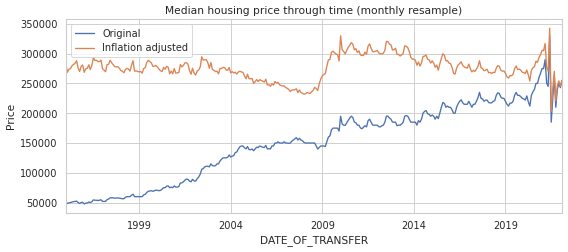

In [ ]:
# hide_input
f, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Median housing price through time (monthly resample)")
ax.set_ylabel("Price")
df.PRICE.resample("M").median().plot(ax=ax, label="Original")
(df.PRICE_ADJ * hpi[-1]).resample("M").median().plot(ax=ax, label="Inflation adjusted")
ax.legend();

The effects of the 2008 financial crisis are very apparent, and there is also a visible seasonality in the series, as we see a rise in price towards summer months, and a fall in the winter. Additionally, we can see more recent instability in house prices due to the COVID-19 pandemic - as it drastically breaks from the seasonal pattern in 2020.

## Feature engineering
Now, I will transform the dataset so that it is more interpretable by a machine learning algorithm; esentially, I need to convert the dataset to numeric values instead of strings. I will also reduce some of the dimensionality currently present in the data; including the cardinality of the categorical columns, and the number of features in the dataset.

### Geospatial information
Currently, the postcode of a property is completely uninterpretable by a predictive model. In order to still leverage this useful location data, I will transform my dataset by using external coordinate data instead.

In [ ]:
pcdLookup = (
    pd.read_csv(PCD_PATH)  # data/raw/postcode-lookup.csv
    .set_index("PCDS")
)
pcdLookup.head()

,LAT,LNG
PCDS,,
AB1 0AA,57.101474,-2.242851
AB1 0AB,57.102554,-2.246308
AB1 0AD,57.100556,-2.248342
AB1 0AE,57.084444,-2.255708
AB1 0AF,57.096656,-2.258102


In [ ]:
df = pd.merge(df, pcdLookup, how="left", left_on="POSTCODE", right_index=True).dropna() # mapping postcodes to lat, long, imd
df = df.drop(columns=["POSTCODE"])
df.head()

,PRICE_ADJ,PRICE,OLD_NEW,PROPERTY_TYPE,BUILT_FORM,TOTAL_FLOOR_AREA,GLAZED_TYPE,EXTENSION_COUNT,NUMBER_HABITABLE_ROOMS,CONSTRUCTION_AGE_BAND,TENURE,MONTH,YEAR,HPI,LAT,LNG
DATE_OF_TRANSFER,,,,,,,,,,,,,,,,
1995-01-01,605.142016,16000.0,N,House,Enclosed Mid-Terrace,99.00,"double glazing, unknown install date",0.0,4.0,England and Wales: before 1900,owner-occupied,1,1995,26.440075,53.723903,-1.882344
1995-01-02,1323.748160,35000.0,N,House,Mid-Terrace,85.00,double glazing installed before 2002,1.0,4.0,England and Wales: 1900-1929,owner-occupied,1,1995,26.440075,52.245071,-0.878169
1995-01-03,567.320640,15000.0,N,House,Semi-Detached,74.00,double glazing installed before 2002,0.0,4.0,England and Wales: 1967-1975,rental (private),1,1995,26.440075,54.961605,-1.419408
1995-01-03,1815.426048,48000.0,N,Bungalow,Detached,78.00,double glazing installed before 2002,1.0,3.0,England and Wales: 1950-1966,owner-occupied,1,1995,26.440075,52.034265,-2.432491
1995-01-03,3101.352831,82000.0,N,Bungalow,Detached,118.88,double glazing installed during or after 2002,0.0,4.0,England and Wales: 1967-1975,rental (private),1,1995,26.440075,50.092749,-5.265793


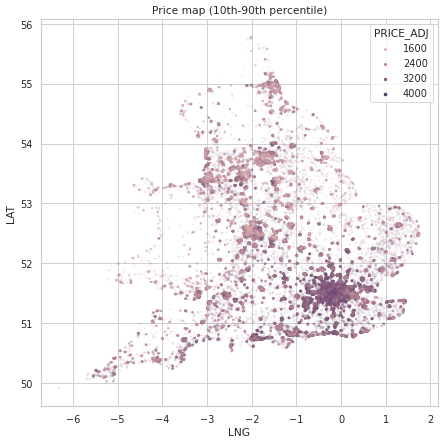

In [ ]:
# hide_input
sample = df[(df.PRICE_ADJ.quantile(.1)<df.PRICE_ADJ) & (df.PRICE_ADJ<df.PRICE_ADJ.quantile(.9))].sample(n=250_000)
f, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=sample, x="LNG", y="LAT", alpha=.075, hue="PRICE_ADJ", size="PRICE_ADJ", sizes=(2, 10), ax=ax)
ax.set_title("Price map (10th-90th percentile)");

### Categorical data
Categorical data can be very useful to a predictive model, if the categories are formatted properly. Since all the data passed into the algorithms must be numerical, the categorical columns must be encoded to integer/float values. One way of doing this is **One-hot Encoding** where each category in a column is binary mapped to a zero or one. However, one-hot encoding each category will lead to an extremely high dimensionality, since each individual categorical column will be mapped to several new columns. Therefore, I will be using **Ordinal Encoding**, which will number/rank the categories instead. Before doing this, I will reduce the high cardinality in the data by removing categories in columns with low counts, and merging categories where appropriate.

In [ ]:
for col in df.select_dtypes("category"):
    df[col] = df[col].cat.remove_unused_categories()

#### Tidying categories and reducing cardinality

In [ ]:
print(df.PROPERTY_TYPE.value_counts())
df = df[df.PROPERTY_TYPE !="Park home"]  # Park home category only has 19 records
df["PROPERTY_TYPE"] = df.PROPERTY_TYPE.cat.remove_unused_categories()
print("\nPROPERTY_TYPE - New categories:", list(df.PROPERTY_TYPE.cat.categories))

House         4091970
Flat           882359
Bungalow       477227
Maisonette     115324
Park home          19
Name: PROPERTY_TYPE, dtype: int64

PROPERTY_TYPE - New categories: ['Bungalow', 'Flat', 'House', 'Maisonette']


In [ ]:
print(df.BUILT_FORM.value_counts())
df["BUILT_FORM"] = (
    df.BUILT_FORM
    .str.replace("Enclosed ", "")
    .str.replace("Mid-","")
    .str.replace("End-","")
    .astype("category")
    .cat.remove_unused_categories()
)
print("\nBUILT_FORM - New categories:", list(df.BUILT_FORM.cat.categories))

Semi-Detached           1800563
Mid-Terrace             1666569
Detached                1241212
End-Terrace              720056
Enclosed End-Terrace      78718
Enclosed Mid-Terrace      59762
Name: BUILT_FORM, dtype: int64

BUILT_FORM - New categories: ['Detached', 'Semi-Detached', 'Terrace']


In [ ]:
prp_map = {
    ("House","Detached"): "Detached house",
    ("House","Semi-Detached"): "Semi-detached house",
    ("House","Terrace"): "Terrace house",

    ("Bungalow","Detached"): "Detached bungalow",
    ("Bungalow","Semi-Detached"): "Semi-detached bungalow",
    ("Bungalow","Terrace"): "Terrace bungalow",

    ("Flat","Detached"): "Flat",
    ("Flat","Semi-Detached"): "Flat",
    ("Flat","Terrace"): "Flat",

    ("Maisonette","Detached"): "Maisonette",
    ("Maisonette","Semi-Detached"): "Maisonette",
    ("Maisonette","Terrace"): "Maisonette",
}

df["N_PROPERTY_TYPE"] = list(zip(df.PROPERTY_TYPE, df.BUILT_FORM))
df["N_PROPERTY_TYPE"] = df.N_PROPERTY_TYPE.map(prp_map).astype("category")

print("N_PROPERTY_TYPE - categories:", list(df.N_PROPERTY_TYPE.cat.categories))

N_PROPERTY_TYPE - categories: ['Detached bungalow', 'Detached house', 'Flat', 'Maisonette', 'Semi-detached bungalow', 'Semi-detached house', 'Terrace bungalow', 'Terrace house']


In [ ]:
print(df.GLAZED_TYPE.value_counts())
df = df[~df.GLAZED_TYPE.isin([
    "triple glazing", "double, known data", "triple, known data" # The categories don't have a lot of records and can therefore be removed
])]
df["GLAZED_TYPE"] = df.GLAZED_TYPE.cat.remove_unused_categories()
print("\nGLAZED_TYPE - New categories:", list(df.GLAZED_TYPE.cat.categories))

double glazing installed before 2002             1992825
double glazing, unknown install date             1732087
double glazing installed during or after 2002    1719791
secondary glazing                                  66849
single glazing                                     45732
triple glazing                                      8175
double, known data                                  1321
triple, known data                                   100
Name: GLAZED_TYPE, dtype: int64

GLAZED_TYPE - New categories: ['double glazing installed before 2002', 'double glazing installed during or after 2002', 'double glazing, unknown install date', 'secondary glazing', 'single glazing']


In [ ]:
print(df.CONSTRUCTION_AGE_BAND.value_counts())
df["CONSTRUCTION_AGE_BAND"] = (
    df.CONSTRUCTION_AGE_BAND
    .str.replace("England and Wales: ", "")
    .replace(["2007-2011", "2012 onwards"], "2007 onwards") # Merging `2007-2011` and `2012 onwards` to `2007 onwards` columns
    .astype("category")
)
print("\nCONSTRUCTION_AGE_BAND - New categories:",
      list(df.CONSTRUCTION_AGE_BAND.cat.categories))

England and Wales: 1900-1929       980478
England and Wales: 1930-1949       930925
England and Wales: 1950-1966       880279
England and Wales: 1967-1975       617905
England and Wales: before 1900     577752
England and Wales: 1983-1990       371020
England and Wales: 1996-2002       304103
England and Wales: 1976-1982       293451
England and Wales: 2003-2006       269729
England and Wales: 1991-1995       193808
England and Wales: 2007 onwards    122659
England and Wales: 2007-2011        14173
England and Wales: 2012 onwards      1002
Name: CONSTRUCTION_AGE_BAND, dtype: int64

CONSTRUCTION_AGE_BAND - New categories: ['1900-1929', '1930-1949', '1950-1966', '1967-1975', '1976-1982', '1983-1990', '1991-1995', '1996-2002', '2003-2006', '2007 onwards', 'before 1900']


In [ ]:
print(df.TENURE.value_counts())
df["TENURE"] = (
    df.TENURE
    .replace("Owner-occupied", "owner-occupied") # merging categories
    .replace("Rented (private)", "rental (private)")
    .replace("Rented (social)", "rental (social)")
    .replace("Not defined - use in the case of a new dwelling for which the intended tenure in not known. It is no","unknown")
    .cat.remove_unused_categories()
)
print("\nTENURE - New categories:", list(df.TENURE.cat.categories))

owner-occupied                                                                                          3988859
rental (private)                                                                                        1140190
Owner-occupied                                                                                           154158
unknown                                                                                                  108172
rental (social)                                                                                           86042
Rented (private)                                                                                          72821
Rented (social)                                                                                            4925
Not defined - use in the case of a new dwelling for which the intended tenure in not known. It is no       2117
Name: TENURE, dtype: int64

TENURE - New categories: ['owner-occupied', 'rental (private)', 'rental (soc

#### Category encoding
I will encode the categories within a column by ranking them in order based on their average property price. I will later store these mappings to a `.json` file to encode inputs when serving requests to the API.

In [ ]:
def RankingEncode(df, target, categories):
    if isinstance(categories, str): categories = [categories]
    return {
        cat: {
            k: i
            for i, k in enumerate(
                df.groupby(cat)[target].median().sort_values().index.values
            )
        }
        for cat in categories
    }

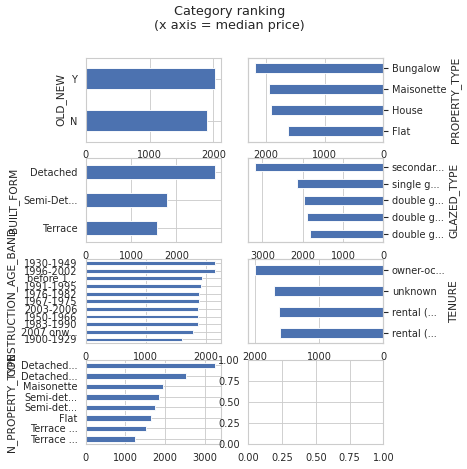

In [ ]:
# hide_input
categories = df.select_dtypes("category").columns
f, axs = plt.subplots((len(categories)+1)//2, 2, figsize=(6,8))
for cat, ax in zip(categories, axs.flatten()):
    df.groupby(cat)["PRICE_ADJ"].median().sort_values().rename(lambda x: x if len(x) <= 10 else x[:8]+"...").plot(kind="barh", ax=ax)
    if np.where(axs==ax)[1] == 1:
        ax.invert_xaxis()  # labels read top-to-bottom
        ax1 = ax.twinx()
        ax1.grid(False)
        ax1.set_ylim(ax.get_ylim())
        ax1.set_yticks(ax.get_yticks())
        ax1.set_yticklabels(ax.get_yticklabels())
        ax1.set_ylabel(cat)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_ylabel("")
f.suptitle("Category ranking\n(x axis = median price)");

In [ ]:
mappings = RankingEncode(df, "PRICE_ADJ", df.select_dtypes("category"))
pprint(mappings)

The categorical variables have been assigned increasing integers corresponding to their effect on the price, while the `OLD_NEW` column has essentially been binary encoded. However, the mappings for `CONSTRUCTION_AGE_BAND` do not make logical sense; therefore I will rank the categories in chronological order instead.

In [ ]:
mappings["CONSTRUCTION_AGE_BAND"] = {
    k: i
    for i, k in enumerate(
        ["before 1900", *list(df.CONSTRUCTION_AGE_BAND.cat.categories)[:-1]]
    )
}
mappings["CONSTRUCTION_AGE_BAND"]

{'before 1900': 0,
 '1900-1929': 1,
 '1930-1949': 2,
 '1950-1966': 3,
 '1967-1975': 4,
 '1976-1982': 5,
 '1983-1990': 6,
 '1991-1995': 7,
 '1996-2002': 8,
 '2003-2006': 9,
 '2007 onwards': 10}

In [ ]:
for col, map_ in mappings.items():
    df[col] = df[col].map(map_)
df.head()

,PRICE_ADJ,PRICE,OLD_NEW,PROPERTY_TYPE,BUILT_FORM,TOTAL_FLOOR_AREA,GLAZED_TYPE,EXTENSION_COUNT,NUMBER_HABITABLE_ROOMS,CONSTRUCTION_AGE_BAND,TENURE,MONTH,YEAR,HPI,LAT,LNG,N_PROPERTY_TYPE
DATE_OF_TRANSFER,,,,,,,,,,,,,,,,,
1995-01-01,605.142016,16000.0,0,1,0,99.00,0,0.0,4.0,0,3,1,1995,26.440075,53.723903,-1.882344,1
1995-01-02,1323.748160,35000.0,0,1,0,85.00,1,1.0,4.0,1,3,1,1995,26.440075,52.245071,-0.878169,1
1995-01-03,567.320640,15000.0,0,1,1,74.00,1,0.0,4.0,4,1,1,1995,26.440075,54.961605,-1.419408,4
1995-01-03,1815.426048,48000.0,0,3,2,78.00,1,1.0,3.0,3,3,1,1995,26.440075,52.034265,-2.432491,6
1995-01-03,3101.352831,82000.0,0,3,2,118.88,2,0.0,4.0,4,1,1,1995,26.440075,50.092749,-5.265793,6


### Feature selection
To reduce the number of unnecessary features, I will test the features' importances, and remove features that are not significant.

I will use two metrics to evaluate feature importance:
1. Mutual information
2. Pearson's correlation coefficient, calculated as such,
$$
r = \frac{(x - \bar x)(y - \bar y) }{\sigma x \cdot \sigma y}
$$

100,000 sample rows


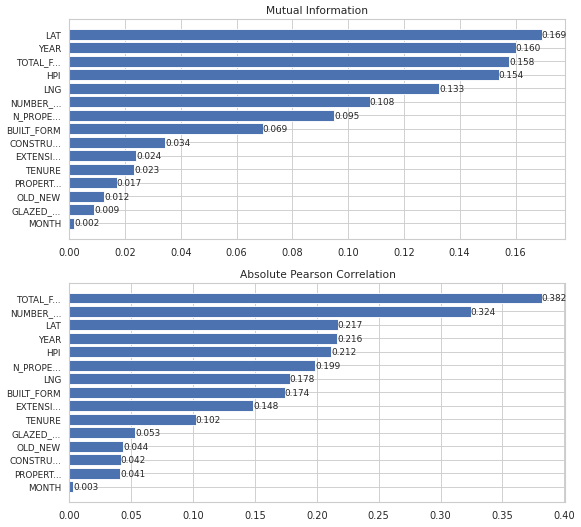

In [ ]:
# hide_input
def plot_imp(imp, columns, horizontal=True, labels=True, dp=3, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
    d = dict(zip(columns, imp))
    d = {k: d[k] for k in sorted(d, key=d.get)}
    ax.set_title("Feature importances")
    if horizontal:
        ax.barh(list(d.keys()), list(d.values()))
        ax.tick_params("y", labelsize="small")
    else:
        ax.bar(list(d.keys()), list(d.values()))
        ax.tick_params("x", rotation=90, labelsize="small")

    if labels:
        ax.bar_label(ax.containers[0],
                     fmt=f"%.{dp}f",
                     label_type="edge",
                     size="small")
    return ax

from sklearn.feature_selection import mutual_info_regression, r_regression

sample = df.sample(n=100_000)
print(f"{len(sample):,} sample rows")

X = sample.drop(columns=["PRICE","PRICE_ADJ"])
y = sample.PRICE

mut = mutual_info_regression(X, y, random_state=0)
pearson = np.abs(r_regression(X, y))

f, axs = plt.subplots(2, figsize=(10, 10))

trunc = [col if len(col) <= 10 else col[:7]+"..." for col in X.columns]
plot_imp(mut, trunc, ax=axs[0]).set_title("Mutual Information")
plot_imp(pearson, trunc, ax=axs[1]).set_title("Absolute Pearson Correlation");

In [ ]:
# hide_input
corr = sample.astype(float).drop(columns="PRICE_ADJ").rename(columns=lambda x: x if len(x) <=8 else x[:5]+"...").corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan

print("Correlation: ")
(corr
    .style
    .background_gradient(cmap=sns.diverging_palette(240, 10, n=9, as_cmap=True), axis=None)
    .highlight_null(null_color='#f1f1f1')
    .set_precision(3))

,PRICE,OLD_NEW,PROPE...,BUILT...,TOTAL...,GLAZE...,EXTEN...,NUMBE...,CONST...,TENURE,MONTH,YEAR,HPI,LAT,LNG,N_PRO...
PRICE,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
OLD_NEW,-0.044,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PROPE...,0.041,-0.127,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
BUILT...,0.174,-0.020,0.303,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
TOTAL...,0.382,-0.043,0.098,0.290,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
GLAZE...,0.053,0.092,-0.063,0.031,0.032,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
EXTEN...,0.148,-0.090,0.079,0.110,0.292,-0.045,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
NUMBE...,0.324,-0.077,0.162,0.338,0.639,-0.000,0.356,nan,nan,nan,nan,nan,nan,nan,nan,nan
CONST...,-0.042,0.299,-0.093,0.177,-0.083,0.156,-0.278,-0.122,nan,nan,nan,nan,nan,nan,nan,nan
TENURE,0.102,-0.127,0.194,0.220,0.155,-0.004,0.105,0.209,-0.032,nan,nan,nan,nan,nan,nan,nan


In [ ]:
# Choosing best features
# Since YEAR and HPI are highly correlated, I will choose HPI between them. 
df = df[["PRICE"#, "PRICE_ADJ", "HPI", "LAT", "LNG", "TOTAL_FLOOR_AREA", "NUMBER_HABITABLE_ROOMS", "N_PROPERTY_TYPE"]]
df["PROPERTY_TYPE"] = df.pop("N_PROPERTY_TYPE")
df

,PRICE,PRICE_ADJ,HPI,LAT,LNG,TOTAL_FLOOR_AREA,NUMBER_HABITABLE_ROOMS,PROPERTY_TYPE
DATE_OF_TRANSFER,,,,,,,,
1995-01-01,16000.0,605.142016,26.440075,53.723903,-1.882344,99.00,4.0,1
1995-01-02,35000.0,1323.748160,26.440075,52.245071,-0.878169,85.00,4.0,1
1995-01-03,15000.0,567.320640,26.440075,54.961605,-1.419408,74.00,4.0,4
1995-01-03,48000.0,1815.426048,26.440075,52.034265,-2.432491,78.00,3.0,6
1995-01-03,82000.0,3101.352831,26.440075,50.092749,-5.265793,118.88,4.0,6
...,...,...,...,...,...,...,...,...
2022-02-24,1850000.0,12657.155077,146.162387,51.568788,-0.780082,238.00,8.0,1
2022-02-24,170000.0,1163.089926,146.162387,51.842156,-2.232514,76.97,4.0,4
2022-02-24,575000.0,3933.980632,146.162387,51.038076,-0.897733,121.00,6.0,7


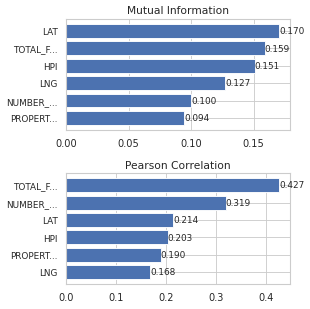

In [ ]:
# hide_input
sample = df.sample(n=100_000)
X = sample.drop(columns=["PRICE","PRICE_ADJ"])
y = sample.PRICE

mut = mutual_info_regression(X, y)
pearson = np.abs(r_regression(X, y))

f, axs = plt.subplots(2, figsize=(5, 5))
trunc = [col if len(col) <= 10 else col[:7]+"..." for col in X.columns]
plot_imp(mut, trunc, ax=axs[0]).set_title("Mutual Information")
plot_imp(pearson, trunc, ax=axs[1]).set_title("Pearson Correlation")
f.tight_layout()

#### Distribution and Skewness
***Skewed*** data can be described as data where the **distribution curve appears to be asymmetrical**. Skewed data can either be *left-skewed* or *right-skewed*. Data with right skew (positive skew) will have a mean > median > mode.
Data with left skew (negative skew) will have a mean < median < mode.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Relationship_between_mean_and_median_under_different_skewness.png/480px-Relationship_between_mean_and_median_under_different_skewness.png)

Skewed data can adversely affect a model's performance especially in regression-based models, such as linear regression, where **the model assumes the data follows normal distribution and has no outliers**. Therefore, the model can tend to **favour more extreme values**, rather than values which are within the true range. Tree-based models, which I may use, are not susceptible to this sort of situation, however, in order to try other models as a possibility, I will need to transform the data to properly balance it.

In [ ]:
# hide
from math import ceil

# Plotting distribution plot for columns
def plot_dist(df, columns=None, ncols=2, kwargs={}):
    if columns is None: columns = df.columns
    
    defaults = {"kde": True}
    kwargs = kwargs.copy()
    for col in columns:
        if col not in kwargs:
            kwargs[col] = defaults
        else:
            for key in defaults.keys():
                if key not in kwargs[col]: 
                    kwargs[col][key] = defaults[key]
                        
    f = plt.figure()
    axs = []
    for i, col in enumerate(columns):
        ax = f.add_subplot(ceil(len(columns) / ncols), ncols, i + 1)
        sns.histplot(df[col].values, **kwargs[col], ax=ax)
        ax.set_xlabel(col if len(col) < 10 else col[:7]+"...", size="small")
        ax.set_ylabel(None)
        axs.append(ax)
    f.suptitle(f"Distribution ({len(df)} rows)")
    f.tight_layout(pad=0.25)
    return axs

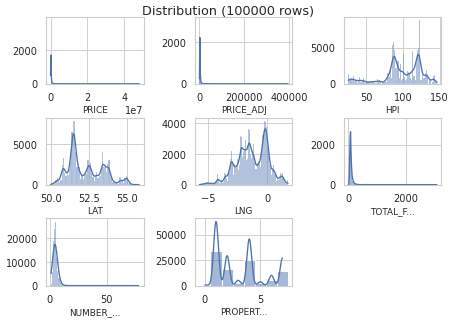

In [ ]:
# hide_input
axs = plot_dist(df.sample(n=100_000), ncols=3, kwargs={
    k: {
        "discrete": True,
        "kde_kws": { "bw_method": 1 }
    }
    for k in ["NUMBER_HABITABLE_ROOMS", "BUILT_FORM", "EXTENSION_COUNT"]
})

The graph clearly shows extreme positive-skew in the price, floor area, room, and crime columns. Since the dataset should ideally follow normal distribution, I will "unskew" this data by removing outliers and potentially transforming the data for a better distribution.

### Outliers
I will detect outliers by filtering values according to their percentile within the dataset.
A data point outside of a given percentile range will be interpreted as an outlier value and will be removed.

In [ ]:
def PercentileOutliers(x, llim, ulim):
    x = np.asarray(x)
    if x.ndim == 2:
        # converting numeric parameter to list of [numeric parameter]
        if isinstance(llim, (int, float)):
            llim = [llim] * x.shape[1]
        if isinstance(ulim, (int, float)):
            ulim = [ulim] * x.shape[1]
        # llim/ulim is a list of percentiles with length of input columns
        lower = np.array(
            [np.percentile(x[:, i], llim[i]) for i in range(x.shape[1])])
        upper = np.array(
            [np.percentile(x[:, i], ulim[i]) for i in range(x.shape[1])])
    else:
        if not isinstance(llim, (int, float)):
            raise ValueError(f"Provide a numeric `llim` for 1-d data not {type(llim)}")
            
        if not isinstance(ulim, (int, float)):
            raise ValueError(f"Provide a numeric `ulim` for 1-d data not {type(ulim)}")

        lower = np.percentile(x, llim)
        upper = np.percentile(x, ulim)

    return (lower < x) & (x < upper) # returning mask with shape of array `x`

In [ ]:
l = len(df)
df = df[PercentileOutliers(
            df[skew],
            # [price, area, rooms]
            llim = [1,  5,  0],
            ulim = [99, 95, 98]
        ).all(axis=1)  # A row must contain no outliers to be included in the dataset
    ]
print(f"{len(df):,} rows, {l-len(df):,} rows removed")

4,903,637 rows, 653,647 rows removed


PRICE_ADJ                 2.009345
TOTAL_FLOOR_AREA          0.909617
NUMBER_HABITABLE_ROOMS    0.390720
dtype: float64

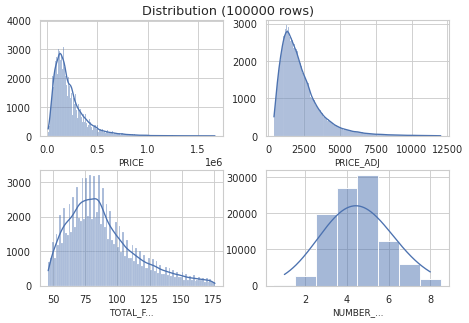

In [ ]:
# hide_input
plot_dist(df[["PRICE",*skew]].sample(n=100_000),
          kwargs={
              "NUMBER_HABITABLE_ROOMS":{
                  "discrete": True,
                  "kde_kws": { "bw_method": 1 }
              }
          })
df[skew].skew()

## Conclusion

I will now save the new dataset; the non-interpretable string categories have now been encoded into numeric values, and much of the outliers and instability has been removed, therefore, the data has been successfully formatted in a way in which a model can understand it to produce predictions.

In [ ]:
json.dump({k.lower(): mappings[k] for k in df.select_dtypes("category").columns},
          open(os.path.join(SERVER_DIR, "encoding.json"), "w"),
          indent=2)  # Saving mappings for remaining categorical columns
df = df.dropna()
df.to_parquet(DATASET_PATH)